✅ 데이터 로드 완료: CSV 및 ArUco JSON
--- 각 뷰/카메라 조합에 대한 대표 이미지 랜덤 선택 ---
   ✅ [left/leftcam] 선택 완료: zed_44377151_left_1747201066.522.jpg
   ✅ [left/rightcam] 선택 완료: zed_44377151_right_1747201079.754.jpg
   ✅ [right/leftcam] 선택 완료: zed_49429257_left_1747201058.366.jpg
   ✅ [right/rightcam] 선택 완료: zed_49429257_right_1747200984.143.jpg
   ✅ [top/leftcam] 선택 완료: zed_49045152_left_1747200834.493.jpg
   ✅ [top/rightcam] 선택 완료: zed_49045152_right_1747201063.186.jpg


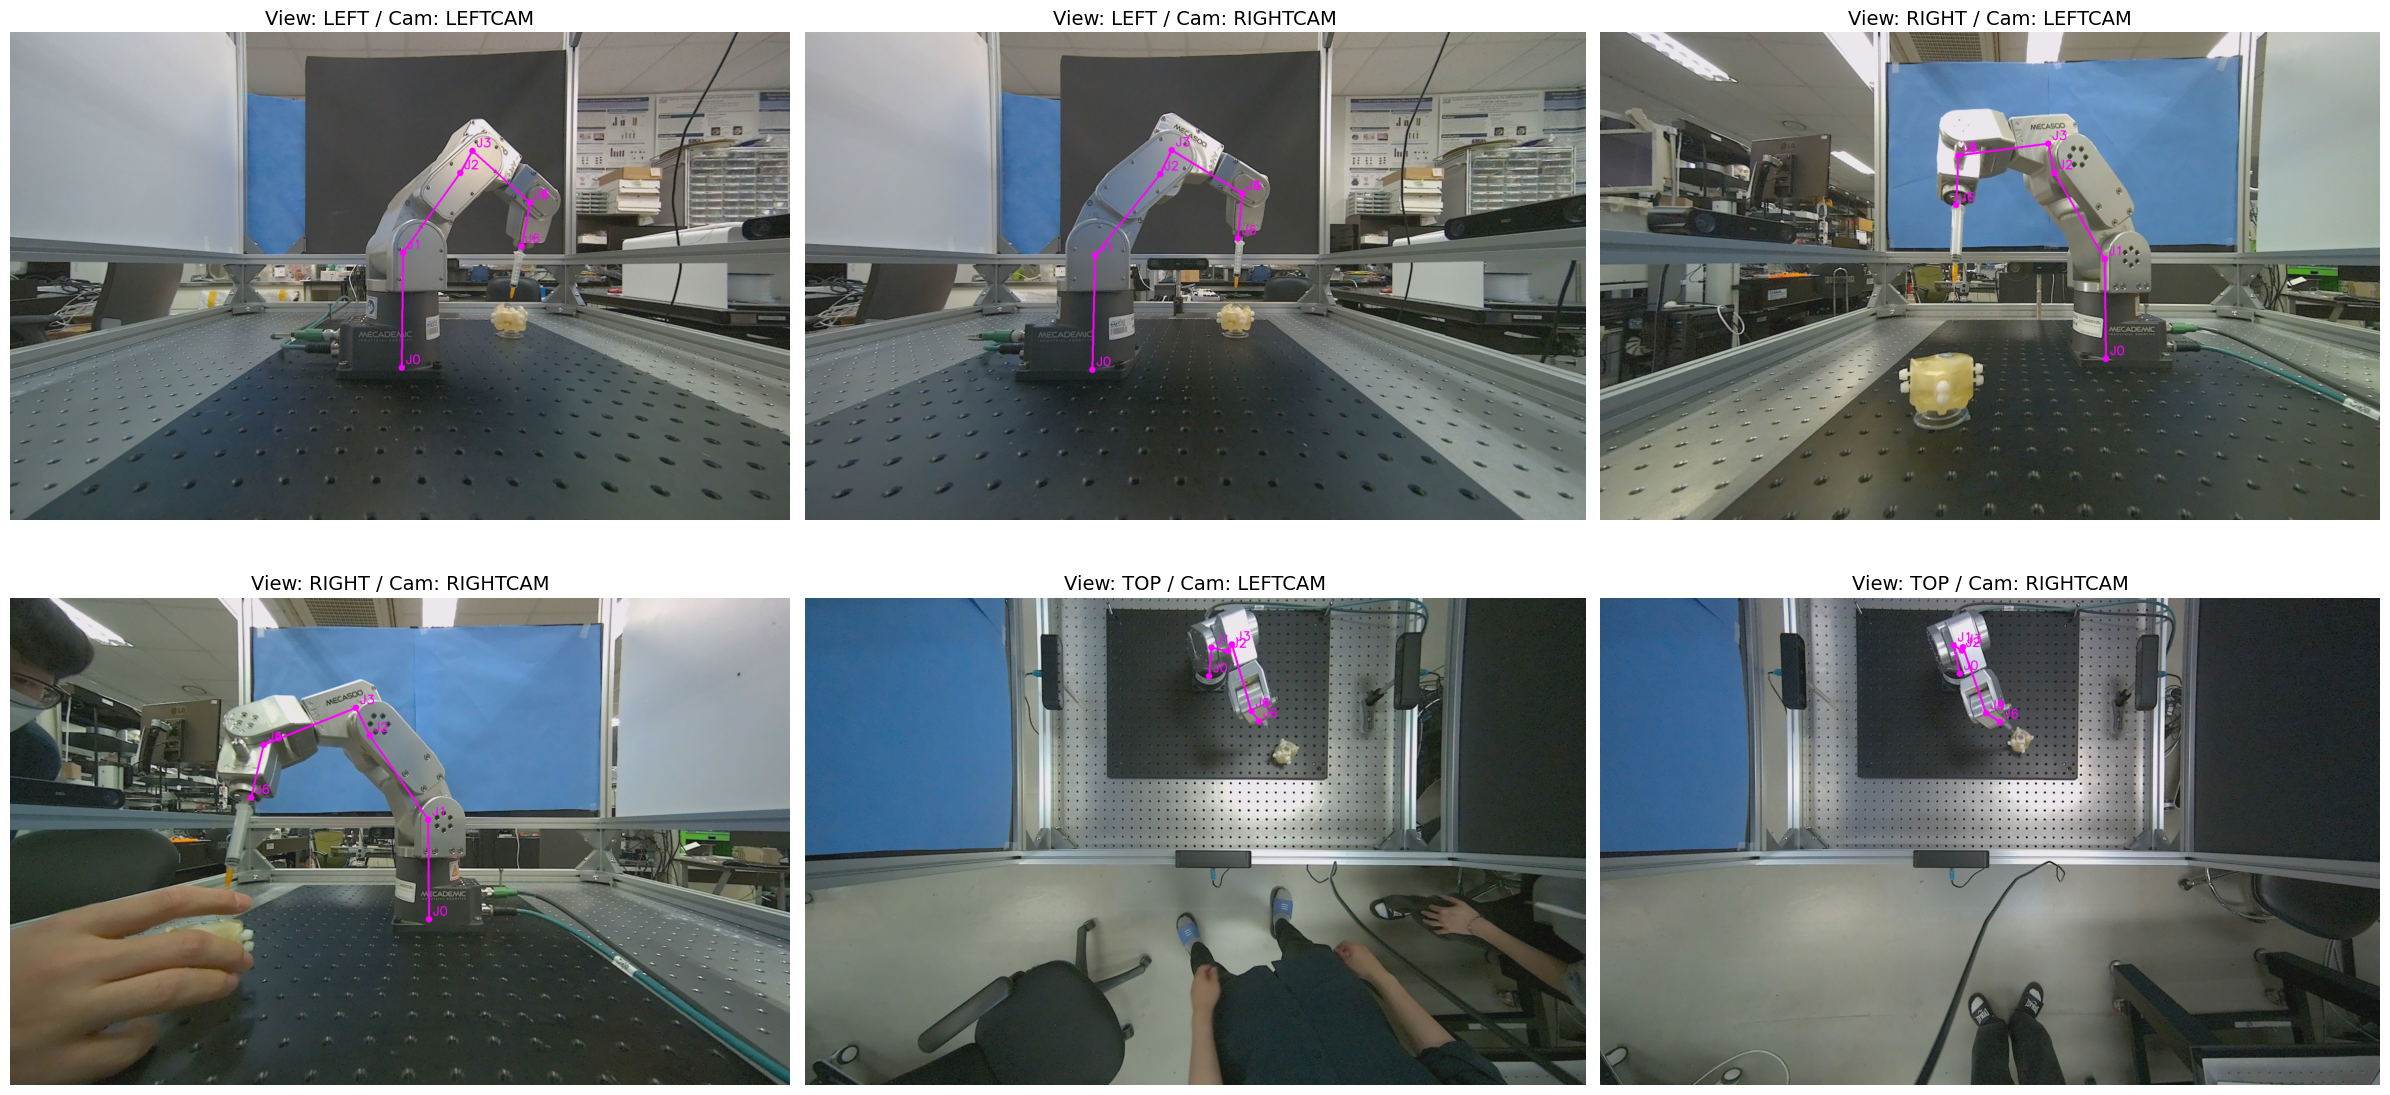

In [15]:
import os
import json
import math
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- ⚙️ 1. 설정 변수 ---

# 동기화된 데이터 CSV 파일 경로
SYNC_CSV_PATH = "../dataset/Meca_insertion/Meca_insertion_matched_joint_angle.csv"
# ArUco 마커 포즈 요약 파일 경로
ARUCO_JSON_PATH = "../dataset/Meca_insertion/Meca_insertion_aruco_final_summary.json"
# 카메라 캘리브레이션 파일이 있는 디렉토리
CALIB_DIR = "../dataset/Meca_insertion/Meca_calib_cam_from_conf"

CAMERA_SERIALS = {"front":'41182735', "right":'49429257', "left":'44377151', "top":'49045152'}

# ===================================================================
# 2. 데이터 로딩 함수 (변경 없음)
# ===================================================================
def load_data_from_sync_row(sync_row, aruco_summary_path, calib_dir):
    """
    동기화된 데이터프레임의 한 행(row)을 기반으로 필요한 모든 데이터를 로드.
    타임스탬프 검색 과정이 필요 없어짐.
    """
    image_path = sync_row['image_path']
    
    # 이미지 경로에서 카메라 정보 파싱
    image_name = os.path.basename(image_path)
    parts = image_name.split('_')
    serial_str = parts[1]
    serial_to_view = {"41182735": "front", "44377151": "left", "49429257": "right", "49045152": "top"}
    view = serial_to_view.get(serial_str)
    cam = parts[2] + "cam"
    if not view: raise ValueError(f"Unknown serial number: {serial_str}")
    
    # ArUco 결과 로드
    with open(aruco_summary_path, 'r') as f:
        aruco_results_all = json.load(f)
    aruco_result = next((item for item in aruco_results_all if item['view'] == view and item['cam'] == cam), None)
    if aruco_result is None:
        raise ValueError(f"No matching ArUco result found for {view}, {cam}")
        
    # 카메라 캘리브레이션 파일 로드
    calib_path = os.path.join(calib_dir, f"{view}_{serial_str}_{cam}_calib.json")
    with open(calib_path, 'r') as f:
        calib = json.load(f)
    camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
    
    return sync_row, image_path, aruco_result, camera_matrix, dist_coeffs

# ===================================================================
# 3. 순기구학 (Forward Kinematics) 계산 (변경 없음)
# ===================================================================
def get_dh_matrix(a, d, alpha, theta):
    """단일 DH 변환 행렬을 계산합니다."""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def forward_kinematics(joint_angles):
    """주어진 관절 각도에 대한 모든 조인트의 3D 좌표를 계산합니다."""
    dh_params = [
        {'alpha': -90, 'a': 0,     'd': 0.135, 'theta_offset': 0},
        {'alpha': 0,   'a': 0.135, 'd': 0,     'theta_offset': -90},
        {'alpha': -90, 'a': 0.038, 'd': 0,     'theta_offset': 0},
        {'alpha': 90,  'a': 0,     'd': 0.120, 'theta_offset': 0},
        {'alpha': -90, 'a': 0,     'd': 0,     'theta_offset': 0},
        {'alpha': 0,   'a': 0,     'd': 0.070, 'theta_offset': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)
    
    # 베이스 좌표계 보정 (X축 180도 회전 후 Z축 90도 추가 회전)
    T_base_correction = np.eye(4)
    rot_x_180 = R.from_euler('x', 180, degrees=True)
    rot_z_90 = R.from_euler('z', 90, degrees=True)
    combined_rotation = rot_z_90 * rot_x_180
    T_base_correction[:3, :3] = combined_rotation.as_matrix()

    T_cumulative = T_base_correction
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = dh_params[i]
        theta = joint_angles[i] + params['theta_offset']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, rvec, tvec, camera_matrix, dist_coeffs):
    """3D 좌표를 2D 이미지 평면에 투영합니다."""
    # rvec과 tvec은 메인 루프에서 미리 준비하여 전달받습니다.
    pixel_coords, _ = cv2.projectPoints(coords_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return pixel_coords.reshape(-1, 2)

# --- 🚀 3. 메인 실행 ---
def main():
    """
    동기화된 CSV 파일을 읽어, 각 뷰/카메라 조합에 대한 랜덤 이미지를 선택하고
    로봇 관절 데이터를 시각화합니다.
    """
    # --- 단계 1: 데이터 로드 ---
    try:
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        with open(ARUCO_JSON_PATH, 'r') as f:
            aruco_results = json.load(f)
    except FileNotFoundError as e:
        print(f"❌ 에러: 필수 파일을 찾을 수 없습니다 - {e}")
        return

    print("✅ 데이터 로드 완료: CSV 및 ArUco JSON")

    # --- 단계 2: 시각화할 데이터 랜덤 선택 ---
    # (이 부분은 문제가 없어 기존 코드 그대로 사용합니다)
    views_to_plot = ['left', 'right', 'top']
    cams_to_plot = ['leftcam', 'rightcam']
    selected_rows = []
    print("--- 각 뷰/카메라 조합에 대한 대표 이미지 랜덤 선택 ---")
    for view in views_to_plot:
        for cam in cams_to_plot:
            cam_short_name = cam.replace("cam", "")
            matching_df = df_sync[
                df_sync['image_path'].str.contains(f"/{view}/") &
                df_sync['image_path'].str.contains(f"_{cam_short_name}_")
            ]
            if not matching_df.empty:
                selected_row = matching_df.sample(n=1).iloc[0]
                selected_rows.append(selected_row)
                img_name = os.path.basename(selected_row['image_path'])
                print(f"   ✅ [{view}/{cam}] 선택 완료: {img_name}")
            else:
                print(f"   ⚠️ [{view}/{cam}] 조합에 해당하는 데이터를 CSV에서 찾을 수 없습니다.")

    if not selected_rows:
        print("❌ 시각화할 데이터를 선택하지 못했습니다.")
        return
        
    # --- 단계 3: 선택된 데이터 시각화 ---
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes = axes.flatten()

    for i, row in enumerate(selected_rows):
        ax = axes[i]
        view, cam = "N/A", "N/A" 
        try:
            image_path = row['image_path']
            joint_angles = [row[f'joint_{j}'] for j in range(1, 7)]

            img_name = os.path.basename(image_path)
            parts = os.path.splitext(img_name)[0].split('_')
            view = [v for v in views_to_plot if f"/{v}/" in image_path][0]
            cam = parts[-2] + "cam"

            aruco_result = next(item for item in aruco_results if item['view'] == view and item['cam'] == cam)
            
            serial = CAMERA_SERIALS[view]
            calib_path = os.path.join(CALIB_DIR, f"{view}_{serial}_{cam}_calib.json")
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)

            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
            dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
            undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

            # ▼▼▼ [수정 1] rvec 값을 Degree에서 Radian으로 변환 ▼▼▼
            # ArUco 파일에 저장된 키 이름이 _deg를 포함하는지 확인하세요. (e.g., 'rvec_x_deg')
            rvec_deg = np.array([
                aruco_result.get('rvec_x_deg', aruco_result.get('rvec_x', 0)), # _deg가 붙은 키를 우선적으로 찾음
                aruco_result.get('rvec_y_deg', aruco_result.get('rvec_y', 0)),
                aruco_result.get('rvec_z_deg', aruco_result.get('rvec_z', 0))
            ], dtype=np.float32)
            rvec = np.deg2rad(rvec_deg) # 단위 변환
            
            tvec = np.array([
                aruco_result['tvec_x'],
                aruco_result['tvec_y'],
                aruco_result['tvec_z']
            ], dtype=np.float32).reshape(3, 1)

            # ▼▼▼ [수정 2] 함수 호출 이름을 'forward_kinematics'로 변경 ▼▼▼
            joint_coords_3d = forward_kinematics(joint_angles)
            pixel_coords = project_to_pixel(joint_coords_3d, rvec, tvec, camera_matrix, np.zeros_like(dist_coeffs))

            # 이미지에 스켈레톤 그리기 (이후 로직은 동일)
            font = cv2.FONT_HERSHEY_SIMPLEX
            for idx, (x, y) in enumerate(pixel_coords.astype(int)):
                cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1)
                cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
                if idx > 0:
                    prev_x, prev_y = pixel_coords[idx-1].astype(int)
                    cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

            ax.imshow(undistorted_img)
            ax.set_title(f"View: {view.upper()} / Cam: {cam.upper()}", fontsize=14)

        except Exception as e:
            print(f"❌ [{view}/{cam}] 시각화 중 오류 발생: {e}")
            ax.set_title(f"Error processing {view}/{cam}", color='red')
        finally:
            ax.axis("off")

    for j in range(len(selected_rows), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

